In [19]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt

In [21]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [11]:


dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [12]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [13]:
len(dataset)

68

In [14]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


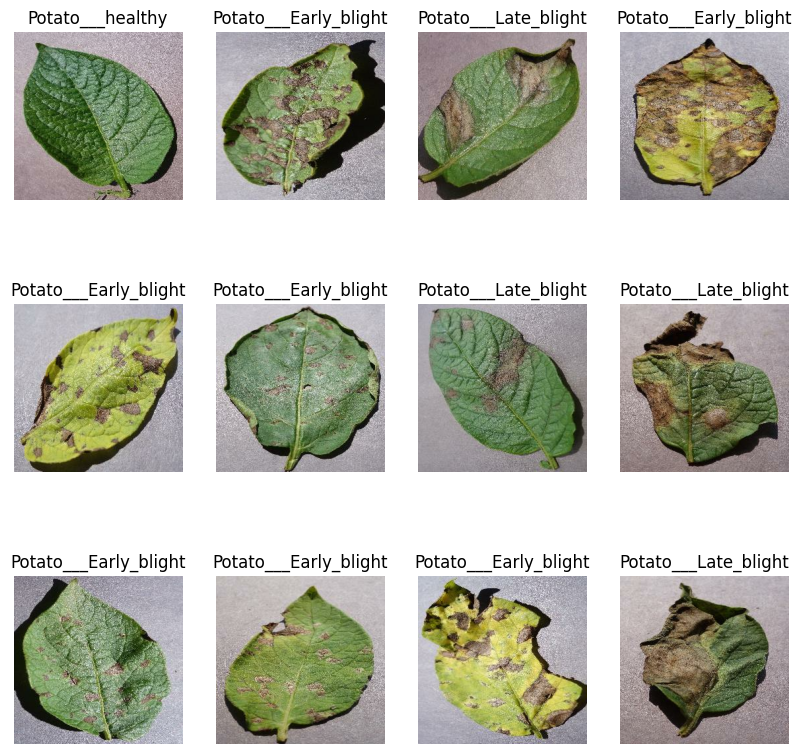

In [20]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [22]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [23]:
train_ds=dataset.take(54)
len(train_ds)

54

In [24]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [27]:
val_size=0.1
len(dataset)*val_Size

6.800000000000001

In [28]:
test_ds=test_ds.skip(6)
len(test_ds)

2

In [32]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+test_split+val_split) ==1

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds =ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [33]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [34]:
len(train_ds)


54

In [35]:
len(val_ds)

6

In [36]:
len(test_ds)

8


Cache, Shuffle, and Prefetch the Dataset

In [38]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Building the Model**

**Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [39]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

**Data Augmentation**
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [48]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**

In [51]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)